<h1 style="color:darkblue; font-size:32px;">MACHINE LEARNING PROJECT</h1>

<h1 style="color:darkblue; font-size:15px;">Group number: 16</h1>
<h1 style="color:darkblue; font-size:15px;">Gal Peleg </h1>
<h1 style="color:darkblue; font-size:15px;">Ohav Zach   </h1>

In [3]:
import pandas as pd
import numpy as np

In [4]:
import pandas as pd
datafile = "train.csv"
df = pd.read_csv(datafile, encoding='utf-8') 
df = df.copy()
df.head()


,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
0,דירה,הצפון הישן החלק המרכזי,"מהר""ל 25",3.0,2,71,NaN,0.0,12.0,467.0,...,1,0,0,1,1,0,0,10150.0,6.0,1005.0
1,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 35,3.0,1,70,NaN,0.0,12.0,240.0,...,1,0,1,0,1,0,0,6600.0,3.0,253.0
2,דירה,הצפון הישן החלק המרכזי,וורמיזה 5,2.5,1,65,NaN,NaN,12.0,400.0,...,1,1,0,0,1,0,1,9000.0,8.0,740.0
3,דירה,הצפון הישן החלק המרכזי,עמנואל הרומי 30,2.0,3,40,NaN,0.0,12.0,100.0,...,0,0,0,0,0,0,0,5800.0,2.0,1206.0
4,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 50,3.0,1,70,NaN,0.0,11.0,250.0,...,1,0,1,0,0,0,1,7700.0,5.0,255.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   property_type         786 non-null    object 
 1   neighborhood          784 non-null    object 
 2   address               758 non-null    object 
 3   room_num              788 non-null    float64
 4   floor                 783 non-null    object 
 5   area                  788 non-null    int64  
 6   garden_area           662 non-null    float64
 7   days_to_enter         608 non-null    float64
 8   num_of_payments       781 non-null    float64
 9   monthly_arnona        628 non-null    float64
 10  building_tax          656 non-null    float64
 11  total_floors          743 non-null    float64
 12  description           783 non-null    object 
 13  has_parking           788 non-null    int64  
 14  has_storage           788 non-null    int64  
 15  elevator              7

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

def prepare_data(df, dataset_type="train"):
    df = df.copy()

    # Remove irrelevant property types
    excluded_types = ['מחסן', 'חניה', 'כללי']
    df = df[~df['property_type'].isin(excluded_types)]

    # Handle price-related filters only on training data
    if dataset_type == "train":
        if 'price' in df.columns:
            df = df[df['price'].notna()]
            df = df[(df['price'] >= 1500) & (df['price'] <= 9000)]
            df = df[(np.abs(zscore(df['price'])) < 3)]
            price_col = df.pop('price')  # Move price to the end
            df['price'] = price_col

    # Drop rows with missing values in key columns
    df = df.dropna(subset=['property_type', 'neighborhood', 'floor', 'num_of_images', 'distance_from_center'])

    # Convert distance to meters if needed
    df['distance_from_center'] = df['distance_from_center'].apply(lambda x: x * 1000 if x < 100 else x)

    # Filter by reasonable ranges
    df = df[(df['area'] >= 20) & (df['area'] <= 200)]
    df = df[df['distance_from_center'] <= 10000]
    df = df[(df['room_num'] >= 1) & (df['room_num'] <= 7)]

    # Fill missing values
    df['garden_area'] = df['garden_area'].fillna(0)
    df['handicap'] = df['handicap'].fillna(0)
    if 'num_of_payments' in df.columns and not df['num_of_payments'].mode().empty:
        df['num_of_payments'] = df['num_of_payments'].fillna(df['num_of_payments'].mode()[0])
    if 'days_to_enter' in df.columns and not df['days_to_enter'].mode().empty:
        df['days_to_enter'] = df['days_to_enter'].fillna(df['days_to_enter'].mode()[0])

    # Drop non-informative column
    df = df.drop(columns=['address'], errors='ignore')

    # Map neighborhoods to broader zones
    zone_map = {
        'לב תל אביב החלק הצפוני': 'מרכז',
        'הצפון הישן החלק הצפוני': 'צפון',
        'הצפון הישן החלק המרכזי': 'צפון',
        'הצפון החדש החלק הצפוני': 'צפון',
        'הצפון החדש החלק הדרומי': 'צפון',
        'הגוש הגדול': 'צפון',
        'תל ברוך צפון': 'צפון',
        'נחלת יצחק': 'מזרח',
        'המרכז הישן': 'מרכז',
        'צפון יפו': 'יפו',
        'לב יפו': 'יפו',
        'יפו ד': 'יפו',
        'שפירא': 'דרום',
        'פלורנטין': 'דרום',
        'נווה שאנן': 'דרום',
        'קריית שלום': 'דרום'
    }
    df['location_zone'] = df['neighborhood'].map(zone_map).fillna('אחר')

    # Feature engineering and type conversions
    df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
    df['total_floors'] = pd.to_numeric(df['total_floors'], errors='coerce')
    df['floor_ratio'] = df['floor'] / df['total_floors'].replace(0, np.nan)

    df['room_x_center'] = df['room_num'] * (df['distance_from_center'] < 2000).astype(int)
    df['area_x_central'] = df['area'] * (df['distance_from_center'] < 2000).astype(int)
    df['is_luxury_apartment'] = ((df['has_balcony'] == 1) & (df['elevator'] == 1) & (df['is_renovated'] == 1)).astype(int)
    df['luxury_score'] = df[['has_balcony', 'is_renovated', 'ac', 'elevator']].sum(axis=1)
    df['luxury_score_cat'] = pd.cut(df['luxury_score'], bins=[-1, 0, 2, 4], labels=['Low', 'Medium', 'High'])

    # Extract features from description text
    df['has_view'] = df['description'].str.contains("נוף|צופה ל", na=False).astype(int)
    df['near_beach'] = df['description'].str.contains("ים|חוף", na=False).astype(int)
    df['quiet_area'] = df['description'].str.contains("שקטה|רחוב שקט", na=False).astype(int)

    # Additional interactions and ratios
    df['area_luxury_interaction'] = df['area'] * df['luxury_score']
    df['room_area_interaction'] = df['room_num'] * df['area']
    df['log_area'] = np.log1p(df['area'])
    df['log_room_area_interaction'] = np.log1p(df['room_area_interaction'])
    df['room_density'] = df['area'] / df['room_num']
    df['log_room_density'] = np.log1p(df['room_density'])

    df['floor_bonus'] = ((df['floor'] > 4) & (df['elevator'] == 1) & (df['has_balcony'] == 1)).astype(int)
    df['many_images'] = (df['num_of_images'] >= 6).astype(int)
    df['central_luxury'] = df['is_luxury_apartment'] * (df['distance_from_center'] < 2000).astype(int)
    df['floor_area_interaction'] = df['floor'] * df['area']
    df['zone_luxury_interaction'] = df['luxury_score'] * (df['location_zone'] == 'מרכז').astype(int)
    df['room_area_ratio'] = df['room_num'] / (df['area'] + 1)
    df['room_to_total_floor_ratio'] = df['room_num'] / (df['total_floors'] + 1)

    # Binning numeric features
    df['distance_cat'] = pd.cut(df['distance_from_center'], bins=[0, 2000, 5000, 10000], labels=['Center', 'Mid', 'Far'])
    df['room_num_binned'] = pd.cut(df['room_num'], bins=[0, 1.5, 3.5, 7], labels=['Small', 'Medium', 'Large'])
    df['garden_area_flag'] = (df['garden_area'] > 0).astype(int)
    df['floor_level'] = pd.cut(df['floor'], bins=[-1, 0, 3, 7, 100], labels=['Basement', 'Low', 'Mid', 'High']).astype('string')

    # Rarity feature based on unique combinations
    df['unique_combo'] = df['room_num'].astype(str) + "_" + df['floor_level'].astype(str) + "_" + df['location_zone'].astype(str)
    combo_counts = df['unique_combo'].value_counts()
    df['rarity_score'] = df['unique_combo'].map(combo_counts)
    df['rarity_score'] = 1 / (df['rarity_score'] + 1)
    df['rare_luxury_combo'] = df['rarity_score'] * df['luxury_score']
    df = df.drop(columns=['unique_combo'], errors='ignore')

    # More interaction features
    df['area_per_floor'] = df['area'] / (df['total_floors'] + 1)
    df['room_num_squared'] = df['room_num'] ** 2
    df['area_room_ratio_squared'] = (df['area'] / (df['room_num'] + 1)) ** 2
    df['floor_weighted_luxury'] = df['floor'] * df['luxury_score']
    df['center_luxury_interaction'] = df['is_luxury_apartment'] * (df['location_zone'] == 'מרכז').astype(int)
    df['elevator_balcony_combo'] = ((df['elevator'] == 1) & (df['has_balcony'] == 1)).astype(int)

    # Define column types for final conversion
    str_cols = ['property_type', 'neighborhood', 'location_zone', 'luxury_score_cat', 'distance_cat', 'room_num_binned', 'floor_level']
    float_cols = ['room_num', 'distance_from_center']
    int_cols = ['floor', 'area', 'garden_area', 'num_of_payments', 'monthly_arnona', 'building_tax', 'total_floors', 'num_of_images']
    binary_cols = ['has_parking', 'has_storage', 'elevator', 'ac', 'handicap', 'has_bars', 'has_safe_room',
                   'has_balcony', 'is_furnished', 'is_renovated', 'has_view', 'near_beach', 'quiet_area',
                   'is_luxury_apartment', 'floor_bonus', 'many_images', 'central_luxury',
                   'garden_area_flag', 'center_luxury_interaction', 'elevator_balcony_combo']

    # Convert column types
    for col in str_cols:
        df[col] = df[col].astype('string')
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    for col in binary_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Apply one-hot encoding
    df = pd.get_dummies(df, columns=str_cols, drop_first=True)

    # Final cleanup
    df = df.dropna()
    df = df.convert_dtypes()

    # Normalize types
    for col in df.columns:
        if df[col].dtype.name == 'boolean':
            df[col] = df[col].astype(int)
        elif "Int" in str(df[col].dtype):
            df[col] = df[col].astype(int)
        elif "Float" in str(df[col].dtype):
            df[col] = df[col].astype(float)

    return df



## Function Explanation: `prepare_data`

- **excluded_types**: Filtered out 'מחסן', 'חניה', 'כללי' — these aren't livable units → improves relevance.
- **price filtering**: Removed unrealistic or missing prices → avoids model distortion from noise.
- **z-score filtering**: Removed extreme price outliers (z > 3) → improves generalization.
- **dropna key columns**: Ensures all inputs are valid → prevents errors and weak training.
- **distance_from_center**: Converts km to meters where needed → standardizes unit for distance.
- **area filter**: Keeps reasonable apartment sizes (20–200 sqm) → avoids rare cases.
- **room_num filter**: Keeps 1–7 rooms → avoids small offices or huge villas.

---

### Filling Missing Values
- **garden_area → 0**: Assumes no garden if missing → reflects default for most apartments.
- **handicap → 0**: Assumes no accessibility unless specified → avoids false positives.
- **num_of_payments → mode**: Most likely payment count → balances realism and simplicity.
- **days_to_enter → mode**: Reasonable assumption of common availability.
- **address → drop**: Noisy and inconsistent → usually not helpful for ML.

---

### Neighborhood Grouping
- **zone_map → location_zone**: Clusters areas into regions (e.g., מרכז) → improves spatial insights.

---

### Feature Engineering
- **floor_ratio**: Floor / total_floors → indicates elevation level, valuable for desirability.
- **room_x_center**: Rooms × proximity → captures apartment size near center.
- **area_x_central**: Area × proximity → reflects central space advantage.
- **is_luxury_apartment**: Binary for luxury combo → strong signal of price premium.
- **luxury_score**: Sum of luxury features → quantifies comfort level.
- **luxury_score_cat**: Bins into Low/Med/High → gives categorical version for modeling.

---

### From Description Text
- **has_view**: Mentions of view → price influence.
- **near_beach**: Mentions sea/beach → likely higher price.
- **quiet_area**: Indicates peace and quiet → desirable for many.

---

### Interaction & Log Features
- **area_luxury_interaction**: Area × luxury → magnifies effect of large, high-end places.
- **room_area_interaction**: Basic size × room count → strong price correlation.
- **log_area**: Log transform → handles skew, stabilizes variance.
- **log_room_area_interaction**: Same reason as above.
- **room_density**: Area / room count → indicates spaciousness.
- **log_room_density**: Log scale for robustness.

---

### Boolean Feature Combinations
- **floor_bonus**: High floor + elevator + balcony → prime unit condition.
- **many_images**: Listings with many photos → signal of serious advertiser.
- **central_luxury**: Luxury + central → boosts desirability.
- **floor_area_interaction**: Height × size → value of elevated space.
- **zone_luxury_interaction**: Luxury × “מרכז” → central luxury premium.
- **room_area_ratio**: Rooms per sqm → crowding indicator.
- **room_to_total_floor_ratio**: Rooms adjusted for building height → reflects density.

---

### Binning & Categoricals
- **distance_cat**: Center / Mid / Far → location bins.
- **room_num_binned**: Small / Medium / Large → simplifies modeling.
- **garden_area_flag**: Binary for garden presence → direct price effect.
- **floor_level**: Basement / Low / Mid / High → helps model preferences for elevation.

---

### Rare Combos
- **rarity_score**: Inverse of combo frequency → rarity premium.
- **rare_luxury_combo**: Rarity × luxury → boosts signal for rare high-end units.

---

### Extra Features
- **area_per_floor**: Efficiency of size per level.
- **room_num_squared**: Captures non-linear effects of rooms.
- **area_room_ratio_squared**: Similar nonlinear effect.
- **floor_weighted_luxury**: Elevation × luxury → desirable combo.
- **center_luxury_interaction**: Central + luxury.
- **elevator_balcony_combo**: Premium condition indicator.

---

### Type Handling
- **str_cols / float_cols / int_cols / binary_cols**: Ensures modeling compatibility.
- **get_dummies**: One-hot encoding of categoricals → numeric for ML.
- **dropna + final conversion**: Clean and ready for model input.


In [8]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib

# Load and prepare the data
df = pd.read_csv("train.csv")  # or "test.csv"
df_cleaned = prepare_data(df, dataset_type="train")  # or "test"

# Convert types
df_cleaned = df_cleaned.convert_dtypes()
for col in df_cleaned.columns:
    if df_cleaned[col].dtype.name == 'boolean':
        df_cleaned[col] = df_cleaned[col].astype(int)
    elif "Int" in str(df_cleaned[col].dtype):
        df_cleaned[col] = df_cleaned[col].astype(int)
    elif "Float" in str(df_cleaned[col].dtype):
        df_cleaned[col] = df_cleaned[col].astype(float)
    elif "string" in str(df_cleaned[col].dtype):
        df_cleaned[col] = df_cleaned[col].astype(str)

# Drop text column
df_cleaned = df_cleaned.drop(columns=['description'], errors='ignore')

# Case 1: Training data
if 'price' in df_cleaned.columns:
    X = df_cleaned.drop(columns=['price'], errors='ignore')
    y = df_cleaned['price']

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(max_iter=10000, random_state=42))
    ])

    param_grid = {
        'model__alpha': [0.01, 0.05, 0.1],
        'model__l1_ratio': [0.7, 0.8, 0.9]
    }

    grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=10)
    grid.fit(X, y)

    en_model = grid.best_estimator_
    feature_names = X.columns

    y_pred_en = en_model.predict(X)
    rmse_en = np.sqrt(mean_squared_error(y, y_pred_en))
    r2_en = r2_score(y, y_pred_en)
    best_params_en = grid.best_params_

    # Save coefficients and top 5 features
    coefs_en = pd.Series(en_model.named_steps['model'].coef_, index=X.columns)
    top_5_features_en = coefs_en.abs().sort_values(ascending=False).head(5)

    # Print results
    print(f"RMSE: {rmse_en:.2f} ₪")
    print(f"R² (Train): {r2_en:.3f}")
    print(f"Best Params: {best_params_en}")
    print("\nTop 5 most influential features:")
    for feature, value in top_5_features_en.items():
        print(f"{feature}: {value:.2f}")

    # Save model
    joblib.dump(en_model, 'trained_model.pkl')
    print("\n Model saved successfully as 'trained_model.pkl'")

# Case 2: Test data
else:
    try:
        X_test = df_cleaned.reindex(columns=en_model.feature_names_in_, fill_value=0)
        y_test_pred = en_model.predict(X_test)
        print("\nPredicted price(s) on test data:")
        for i, pred in enumerate(y_test_pred):
            print(f"Row {i+1}: {pred:.2f} ₪")
    except Exception:
        pass


RMSE: 762.60 ₪
R² (Train): 0.743
Best Params: {'model__alpha': 0.1, 'model__l1_ratio': 0.7}

Top 5 most influential features:
room_num_binned_Medium: 348.73
log_room_area_interaction: 346.05
log_area: 329.73
area_luxury_interaction: 321.45
property_type_דירה להשכרה: 321.18

 Model saved successfully as 'trained_model.pkl'


## Model Explanation: ElasticNet Pipeline

### Step 1: Splitting Features and Target
-  Separate `X` (features) and `y` (target = price).
-  To allow the model to learn a mapping from input features to the target output.

---

### Step 2: Data Type Conversion
- Ensures all columns are in numerical format (int, float, or string).
-  scikit-learn models cannot handle object or mixed types. Standardization and regression require strict numeric input.

---

### Step 3: Drop Unused Text Fields
-  Drops the `description` column.
-  It's unstructured text not encoded or preprocessed — removing avoids noise or model errors.

---

### Step 4: Build Pipeline
- **StandardScaler**:
  -  Scales features to zero mean and unit variance.
  -  ElasticNet is sensitive to feature scales; scaling ensures fair regularization across all features.

- **ElasticNet Model**:
  -  Combines L1 (Lasso) and L2 (Ridge) regularization.
  -  Balances feature selection (L1) and coefficient shrinkage (L2), especially useful in high-dimensional datasets.

---

### Step 5: Hyperparameter Grid Definition
- **alpha**: Regularization strength.
- **l1_ratio**: Mix between L1 (Lasso) and L2 (Ridge).
-  These control how much penalty is applied to coefficients, helping prevent overfitting and improving generalization.

---

### Step 6: GridSearchCV with 10-Fold Cross-Validation
-  Trains the pipeline using 10 different train-validation splits.
-  Ensures robust model evaluation, reduces the risk of overfitting to a specific split.

---

### Step 7: Extract Best Model
-  Selects the model with the best validation R² from the grid.
-  Automatically tunes the model for optimal performance based on data.

---

### Step 8: Predictions and Evaluation
- **RMSE**: Measures prediction error in original price units (₪).
- **R²**: Measures variance explained by the model.
-  Both give complementary insights into model accuracy.

---

### Step 9: Coefficients and Feature Importance
-  Extracts feature weights (coefficients).
-  Larger absolute values indicate stronger influence on the predicted price.
- **Top 5**: Highlights the most predictive features for interpretation.

---


## Selected Features for Prediction: Explanation

In our approach, we did **not** manually select specific columns. Instead, we allowed the **ElasticNet model** to automatically determine which features are most important based on their contribution to reducing the error during training.

### How features were handled:
- **All numeric and categorical features** from the cleaned dataset were used.
- Only **irrelevant or unhelpful columns** (such as free-text descriptions and addresses) were explicitly removed.
- After this, **no manual filtering or selection** of features was applied.

This strategy:
- Allows the model to learn from a **rich feature space** that includes both original and engineered features.
- Enables **regularization in ElasticNet** to automatically reduce the weight of less relevant features.
- Ensures that the final model is **data-driven**, rather than manually biased by prior assumptions.

### Why ElasticNet helps with feature selection:
**ElasticNet** is a regression model with built-in **regularization**, combining both **L1 (Lasso)** and **L2 (Ridge)** penalties.

As a result:
- Features that do not contribute to prediction (or even harm it) are assigned coefficients **close to zero** — or even exactly zero.
- This means the model performs **automatic feature selection** as part of the training process.

After training, we extracted the **top 5 most influential features** based on the absolute value of their coefficients. This helps interpret which features contributed the most to the model — but **the model itself made that decision**, not us.


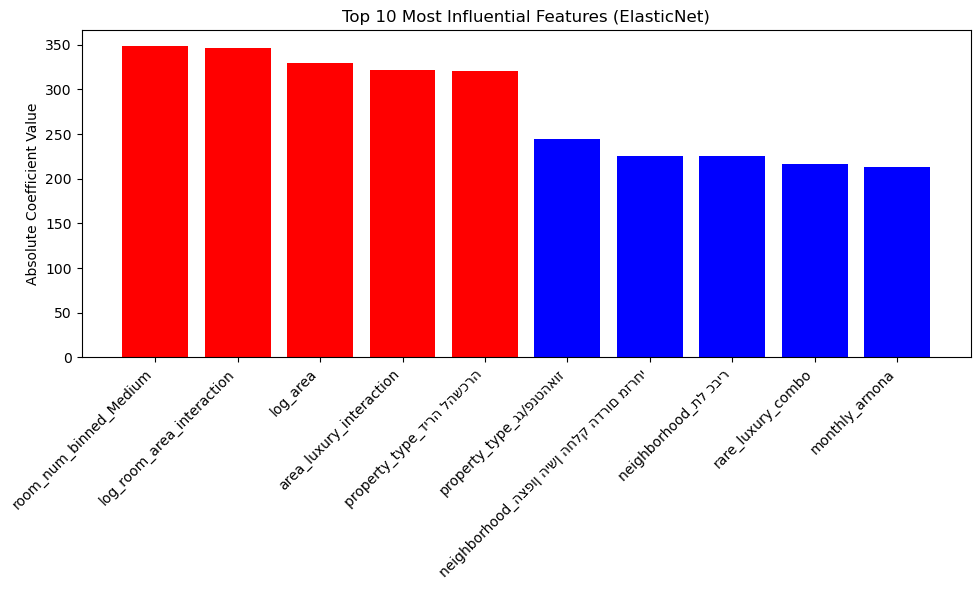

In [11]:
import matplotlib.pyplot as plt

# Sort all features by importance (absolute value of coefficients)
top_10_features_en = coefs_en.abs().sort_values(ascending=False).head(10)

# Define colors: red for top 5, blue for others
colors = ['red' if feature in top_5_features_en.index else 'blue' for feature in top_10_features_en.index]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_10_features_en.index, top_10_features_en.values, color=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Influential Features (ElasticNet)')
plt.ylabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()




In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the data manually and set dataset type
df = pd.read_csv("train.csv")  # ← Change to "test.csv" when needed
df_cleaned = prepare_data(df, dataset_type="train")  # ← Change to "test" if using test data

# Convert types
df_cleaned = df_cleaned.convert_dtypes()
for col in df_cleaned.columns:
    if df_cleaned[col].dtype.name == 'boolean':
        df_cleaned[col] = df_cleaned[col].astype(int)
    elif "Int" in str(df_cleaned[col].dtype):
        df_cleaned[col] = df_cleaned[col].astype(int)
    elif "Float" in str(df_cleaned[col].dtype):
        df_cleaned[col] = df_cleaned[col].astype(float)
    elif "string" in str(df_cleaned[col].dtype):
        df_cleaned[col] = df_cleaned[col].astype(str)

# Drop free-text column
df_cleaned = df_cleaned.drop(columns=['description'], errors='ignore')

# Case 1: Training data with price column
if 'price' in df_cleaned.columns:
    X = df_cleaned.drop(columns=['price', 'property_type', 'address'], errors='ignore')
    y = df_cleaned['price']
    features_to_use = X.columns.tolist()

    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    }

    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=10,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X, y)
    final_rf_model = grid_search.best_estimator_

    y_pred_all = final_rf_model.predict(X)
    rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
    r2_all = r2_score(y, y_pred_all)

    model_rmse = rmse_all
    model_r2 = r2_all
    model_best_params = grid_search.best_params_

    feature_importance_series = pd.Series(final_rf_model.feature_importances_, index=features_to_use)
    top_5_features = feature_importance_series.sort_values(ascending=False).head(5)

    print(" Model trained using GridSearchCV (light version) with 10-fold CV.")
    print(f"Best Parameters: {model_best_params}")
    print(f"RMSE (Train - All Data): {model_rmse:.2f} ₪")
    print(f"R² (Train - All Data)  : {model_r2:.3f}\n")
    print("Top 5 most important features:")
    print(top_5_features)



# Case 2: Test data with no price column
else:
    try:
        X_test = df_cleaned.drop(columns=['property_type', 'address'], errors='ignore')
        X_test = X_test.reindex(columns=final_rf_model.feature_names_in_, fill_value=0)
        y_test_pred = final_rf_model.predict(X_test)

        print("\nPredicted price(s) on test data:")
        for i, pred in enumerate(y_test_pred):
            print(f"Row {i+1}: {pred:.2f} ₪")
    except Exception as e:
        print("\n Prediction failed:", e)




 Model trained using GridSearchCV (light version) with 10-fold CV.
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RMSE (Train - All Data): 633.06 ₪
R² (Train - All Data)  : 0.823

Top 5 most important features:
room_area_interaction        0.070595
log_room_area_interaction    0.068927
area                         0.058614
log_area                     0.051456
building_tax                 0.048834
dtype: float64


## Selected Features for Prediction: Explanation (Random Forest)

The Random Forest model does **not require manual feature selection**. Instead, it evaluates all available features during training and internally determines their importance.

---

### 1. **Included Features**
-  All numerical, binary, and one-hot encoded features were kept — enabling the model to learn from full structured data.

---

### 2. **Excluded Features**
-  We excluded only a few columns:
  - `'price'` — the target variable.
  - `'property_type'` — redundant after encoding.
  - `'address'`, `'description'` — unstructured or non-numeric.

---

### 3. **Feature Evaluation**
-  Random Forest evaluates feature splits across multiple trees. Less useful features are naturally assigned low importance.

---

### 4. **Top Features**
-  After training, we extracted the top 5 most important features using the model’s built-in `feature_importances_` method.

---



## Model Training & Evaluation Steps

---

### 1. **Feature Preparation**
- Created `X_all` by dropping irrelevant columns from the cleaned dataset.
- Set `y_all` as the target (`price`).

---

### 2. **Model Definition and Parameter Grid**
- Used `RandomForestRegressor` as the base model.
- Defined a lightweight `param_grid` for hyperparameter tuning via `GridSearchCV`.

---

### 3. **10-Fold Cross-Validation with Grid Search**
- Applied `GridSearchCV` with `cv=10` to search for the best parameters using `r²` as the scoring metric.

---

### 4. **Model Selection and Evaluation**
- Retrieved `best_estimator_` from the grid search.
- Predicted prices on the full dataset.
- Calculated `RMSE` and `R²` to assess performance.

---

### 5. **Feature Importance Extraction**
- Used `final_rf_model.feature_importances_` to rank features.
- Displayed the **top 5 most influential features** to interpret the model.


---
## Why GridSearchCV was Chosen:

We selected **GridSearchCV** as the optimization method for our model because it allows for a **systematic and exhaustive search** over a defined set of hyperparameter combinations. This approach is:

- **Transparent**: It evaluates every combination of parameters in the specified grid, making the selection process clear and reproducible.
- **Robust**: It performs **k-fold cross-validation** (in our case, 10-fold), ensuring that the selected model generalizes well and is not overfitted to a specific train-test split.
- **Reliable**: While other methods like RandomizedSearchCV can be faster, GridSearchCV is more thorough when the parameter grid is small to moderate — which was the case in our project.

Overall, GridSearchCV was the most appropriate choice due to the **manageable search space**, the need for **controlled experimentation**, and the goal of ensuring **reproducible and optimal model performance**.


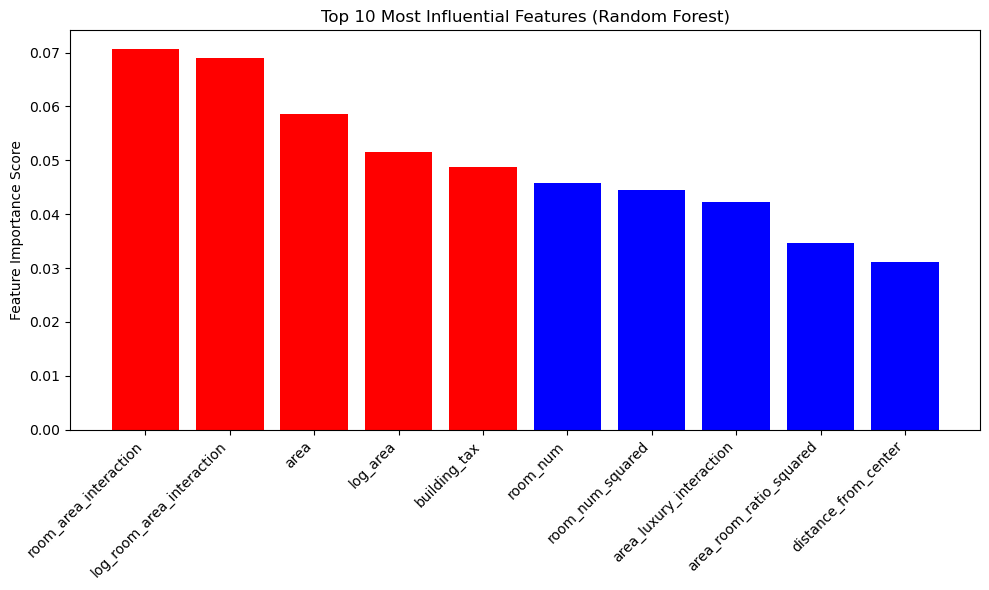

In [14]:
# Extract top 10 important features from the Random Forest model
top_10_rf_features = feature_importance_series.sort_values(ascending=False).head(10)
highlighted_rf = top_5_features.index

# Assign colors: red for top 5, blue for others
colors_rf = ['red' if feature in highlighted_rf else 'blue' for feature in top_10_rf_features.index]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_10_rf_features.index, top_10_rf_features.values, color=colors_rf)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Influential Features (Random Forest)')
plt.ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()


<h1 style="color:darkblue; font-size:40px;">Comparison between the models</h1>

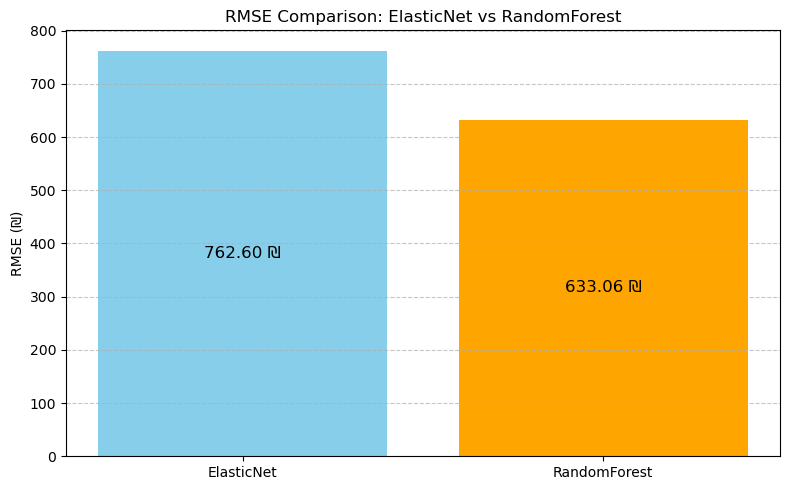

In [16]:
# Using the previously defined variables directly
rmse_values = {
    'ElasticNet': rmse_en,
    'RandomForest': model_rmse
}

# Create the bar chart again with dynamic values
plt.figure(figsize=(8, 5))
bars = plt.bar(rmse_values.keys(), rmse_values.values(), color=['skyblue', 'orange'])

# Add dynamic RMSE values to the bars
for bar, label in zip(bars, rmse_values.values()):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f"{label:.2f} ₪", ha='center', va='center', fontsize=12, color='black')

plt.title('RMSE Comparison: ElasticNet vs RandomForest')
plt.ylabel('RMSE (₪)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


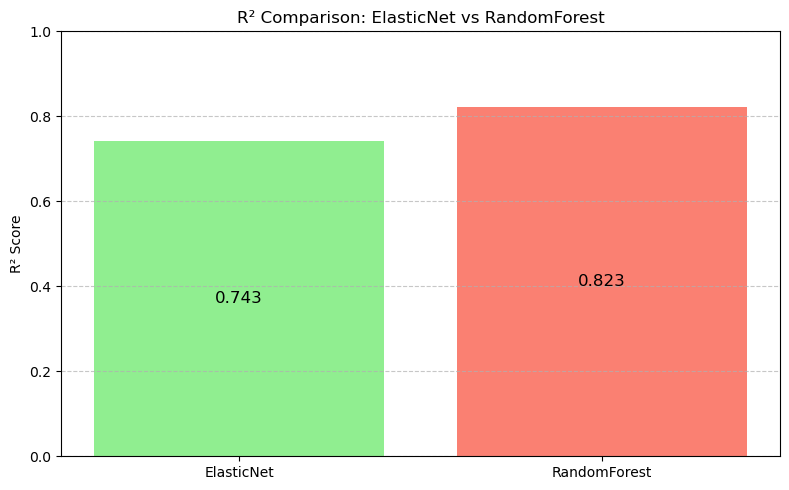

In [17]:
# Prepare R² values for comparison
r2_values = {
    'ElasticNet': r2_en,
    'RandomForest': model_r2
}

# Create the bar chart for R² comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(r2_values.keys(), r2_values.values(), color=['lightgreen', 'salmon'])

# Add dynamic R² values to the bars
for bar, label in zip(bars, r2_values.values()):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f"{label:.3f}", ha='center', va='center', fontsize=12, color='black')

plt.title('R² Comparison: ElasticNet vs RandomForest')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Model Comparison: ElasticNet vs. Random Forest

| Model         | RMSE (₪) | R² Score |
|---------------|-----------|----------|
| ElasticNet    | 762.60    | 0.743    |
| Random Forest | 633.06    | 0.823    |

---

### Conclusion:
The **Random Forest model achieved better performance** than ElasticNet, demonstrating both a **lower RMSE** and a **higher R² score**.

This outcome is expected due to the nature of each model:  
ElasticNet is a **regularized linear regression** model that performs well when the relationships between features and target are mostly linear. It is especially helpful for **automatic feature selection** and **reducing overfitting** in simpler data structures. However, its linear nature limits its ability to capture complex interactions.

Random Forest, in contrast, is a **non-linear ensemble model** based on decision trees. It naturally handles **feature interactions**, **non-linear patterns**, and **hierarchical relationships** within the data — making it particularly effective for complex datasets with rich, engineered features like ours.  
As a result, it was able to explain more variance and generate **more accurate predictions**.

> **Note**: The metrics shown here are based on results obtained during a specific run performed at home.  
> The **bar charts use dynamic variables**, so **slight differences between this table and the graphs** may appear.


In [19]:
import pandas as pd

# Create a DataFrame to compare top 5 features from both models
comparison_df = pd.DataFrame({
    'ElasticNet Top 5': top_5_features_en.index.tolist(),
    'RandomForest Top 5': top_5_features.index.tolist()
})

# Highlight cells that appear in both columns (shared features)
def highlight_shared(val):
    if val in top_5_features_en.index and val in top_5_features.index:
        return 'background-color: lightgreen'
    return ''

# Apply the highlighting and display the styled DataFrame
comparison_df.style.applymap(highlight_shared)



C:\Users\galpe\AppData\Local\Temp\ipykernel_22904\2575131007.py:16: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  comparison_df.style.applymap(highlight_shared)


,ElasticNet Top 5,RandomForest Top 5
0,room_num_binned_Medium,room_area_interaction
1,log_room_area_interaction,log_room_area_interaction
2,log_area,area
3,area_luxury_interaction,log_area
4,property_type_דירה להשכרה,building_tax


### Shared Important Features: Explanation

The following features were identified as top contributors by both models (ElasticNet and Random Forest), suggesting they have strong predictive power:

- **log_room_area_interaction**: Captures the interaction between room count and apartment size. Its logarithmic transformation stabilizes variance and highlights proportional relationships — a key factor in pricing.
- **log_area**: Reflects the size of the apartment on a compressed scale, allowing both models to better capture diminishing returns in pricing as area increases.

These features make intuitive sense in real estate: both the scale of a property and its qualitative features. The fact that **both linear (ElasticNet)** and **non-linear (Random Forest)** models emphasized them suggests they are robust and generalizable indicators.


### Model Similarities and Differences: ElasticNet vs. Random Forest

In our project, both **ElasticNet** and **Random Forest** were trained on the same enriched dataset, which included dozens of engineered features such as area-based metrics, luxury indicators, and location groupings. Despite their very different modeling strategies, both models showed some **consistency** in what they considered important — while also differing in ways that make sense given their nature.

---

###  Similarities:

- Both models ranked features like **`log_room_area_interaction`**, **`log_area`** among their top 5, even though one is linear and the other is tree-based.  
- These shared features reflect **core aspects of real estate pricing** — size, efficiency, which naturally affect rental prices regardless of model type.
- This consistency strengthens the **validity of our feature engineering choices**, as both models independently highlighted similar dimensions.

---

###  Differences and Why They Occur:

- **ElasticNet** is a linear model with regularization (L1 + L2), so it captures **direct linear trends** and penalizes complexity. It favored features like:
  - `property_type_דירה להשכרה`
  - `room_num_binned_Medium`  
  These have clear linear effects and are easy to interpret.
  
- **Random Forest**, on the other hand, can model **non-linear relationships** and complex interactions. It ranked features like:
  - `room_area_interaction` and `building_tax`
  - These may not have strong linear correlations but capture **thresholds** or **interaction effects** (e.g., tax bands, non-linear space value).

- The fact that Random Forest outperformed ElasticNet (higher R², lower RMSE) is likely due to its ability to **leverage the complexity** in our engineered feature space.

---

###  Conclusion:

The models share several important features, especially those based on **area and spatial layout**, which confirms that these were meaningful choices in our preprocessing.  
At the same time, each model brings a different perspective:
- **ElasticNet promotes simplicity and interpretability**
- **Random Forest extracts deeper patterns from the data**
